In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import pandas as pd

df = pd.read_csv('data/digit-recognizer/train.csv')

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(df.shape)  

(42000, 785)


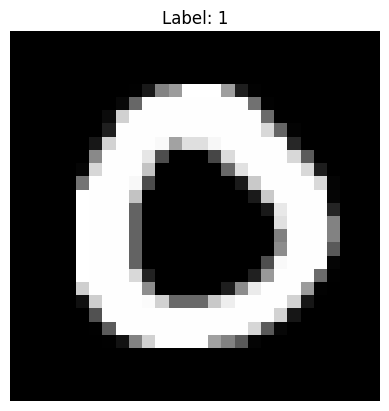

In [5]:
sample = df.iloc[4, 1:].values.reshape(28, 28)
plt.imshow(sample, cmap="gray")
plt.title(f"Label: {df.iloc[0, 0]}")
plt.axis("off")
plt.show()

In [6]:
data = np.array(df)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]

In [7]:
data.shape

(42000, 785)

In [8]:
X_train = X_train.astype(np.float32) / 255.0   # scale 0‒1
X_dev   = X_dev.astype(np.float32)  / 255.0
Y_train = Y_train.astype(int)
Y_dev   = Y_dev.astype(int)

In [9]:
H = 128              # hidden-layer width (was 10)

def init_params():
    W1 = np.random.randn(H, 784) * np.sqrt(2/784)   # He init
    b1 = np.zeros((H, 1))
    W2 = np.random.randn(10, H) * 0.01
    b2 = np.zeros((10, 1))
    return W1, b1, W2, b2
def ReLU(Z):
    return np.maximum(0, Z)

def deriv_ReLU(Z):
    return (Z > 0).astype(float)

def softmax(Z):
    Z_shift = Z - np.max(Z, axis=0, keepdims=True)
    expZ    = np.exp(Z_shift)
    return expZ / np.sum(expZ, axis=0, keepdims=True)

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T  # (10 × m)

def back_prop(Z1, A1, Z2, A2, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)              # (10 × m)
    dZ2 = A2 - one_hot_Y
    dW2 = (1/m) * dZ2 @ A1.T            # @ same as dot
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = W2.T @ dZ2 * deriv_ReLU(Z1)
    dW1 = (1/m) * dZ1 @ X.T
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2



In [10]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, epochs=5, lr=0.01, batch_size=256):
    W1, b1, W2, b2 = init_params()
    m = Y.size
    for epoch in range(epochs):
        perm = np.random.permutation(m)
        X, Y = X[:, perm], Y[perm]
        for k in range(0, m, batch_size):
            X_batch = X[:, k:k+batch_size]
            Y_batch = Y[k:k+batch_size]

            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_batch)
            dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2,
                                           W2, X_batch, Y_batch)
            W1 -= lr * dW1
            b1 -= lr * db1
            W2 -= lr * dW2
            b2 -= lr * db2

        # monitor once per epoch
        _, _, _, A2_full = forward_prop(W1, b1, W2, b2, X)
        acc = get_accuracy(get_predictions(A2_full), Y)
        print(f"Epoch {epoch+1}/{epochs}  —  accuracy {acc:.3f}")
    return W1, b1, W2, b2

In [12]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train)

[2 2 2 ... 6 3 2] [5 2 2 ... 4 3 1]
Epoch 1/5  —  accuracy 0.648
[7 9 0 ... 1 1 8] [7 9 5 ... 1 1 8]
Epoch 2/5  —  accuracy 0.730
[3 2 2 ... 2 6 8] [3 2 2 ... 2 6 8]
Epoch 3/5  —  accuracy 0.785
[6 4 0 ... 2 8 6] [6 4 0 ... 2 8 2]
Epoch 4/5  —  accuracy 0.822
[9 0 7 ... 4 0 3] [9 0 7 ... 4 0 3]
Epoch 5/5  —  accuracy 0.838


In [13]:
print(W1, b1, W2, b2)

[[ 0.03998375 -0.11832125  0.02272039 ...  0.01958803  0.01521402
  -0.00040386]
 [ 0.0051166   0.02765473 -0.01772805 ...  0.10289417 -0.02539779
  -0.01422918]
 [ 0.04351211  0.06667214  0.0466439  ...  0.10983388  0.04395802
   0.04726722]
 ...
 [ 0.03810951 -0.01884699  0.042492   ...  0.00143672  0.06204552
  -0.02742922]
 [ 0.01221698 -0.00496353 -0.05258754 ...  0.03603819 -0.0568958
   0.0185419 ]
 [-0.00410685  0.02592188  0.06985044 ... -0.00671312  0.02014729
   0.01703673]] [[ 0.02393676]
 [ 0.02384063]
 [ 0.02037503]
 [ 0.03937781]
 [ 0.01799033]
 [ 0.01347149]
 [ 0.02218584]
 [ 0.01196094]
 [ 0.00571964]
 [ 0.0062927 ]
 [ 0.01867979]
 [ 0.00107717]
 [ 0.0047286 ]
 [ 0.02238969]
 [ 0.00772049]
 [ 0.02567112]
 [ 0.02476595]
 [ 0.02114444]
 [ 0.00426416]
 [ 0.00144517]
 [ 0.0075659 ]
 [ 0.00709961]
 [ 0.01834975]
 [ 0.0028314 ]
 [ 0.01217626]
 [ 0.0118952 ]
 [ 0.01310678]
 [ 0.00188926]
 [ 0.01210598]
 [-0.00247869]
 [ 0.01713322]
 [ 0.00875521]
 [ 0.03583607]
 [ 0.02457634]